In [10]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd
import datetime as dt

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [13]:
# Create the connection engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [14]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [15]:
# View all of the classes that automap found
Base.classes.keys()

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# List of column names and types for measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
# List of column names and types for measurement
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [19]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

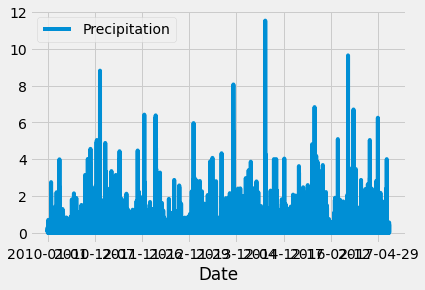

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = session.query(func.min(Measurement.date)).all()[0][0]

# Calculate the date one year from the last date in data set.
last_year = dt.datetime.strptime(date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rain_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(rain_results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df = precipitation_df.dropna()

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
plot = precipitation_df.plot().get_figure()


In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [22]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station)
print("There are {} stations.".format(total_stations.count()))

There are 9 stations.


In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
    
most_active_station_name = ""
most_active_station = active_stations[0][0]

for location in total_stations:
    if(location.station == active_stations[0][0]):
        most_active_station_name = location.name
print(f"The most active stations information is as follows: ")
print(f" Name    : {most_active_station_name} ")
print(f" Station : {active_stations[0][0]}")
print(f" Count   : {active_stations[0][1]}")
print("")
print("List of the stations and the counts in descending order:")
print("Station        Counts")
print("-----------------------")

for active_stations in active_stations:
    print(active_stations[0], "   ", active_stations[1])

The most active stations information is as follows: 
 Name    : WAIHEE 837.5, HI US 
 Station : USC00519281
 Count   : 2772

List of the stations and the counts in descending order:
Station        Counts
-----------------------
USC00519281     2772
USC00519397     2724
USC00513117     2709
USC00519523     2669
USC00516128     2612
USC00514830     2202
USC00511918     1979
USC00517948     1372
USC00518838     511


In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_frequencies = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"The Lowest, Highest & the average temperature for most active station {most_active_station} is :")
print(f" Low  : {temperature_frequencies[0][0]}")
print(f" High : {temperature_frequencies[0][1]}")
print(f" Avg  : {temperature_frequencies[0][2]}")

The Lowest, Highest & the average temperature for most active station USC00519281 is :
 Low  : 54.0
 High : 85.0
 Avg  : 71.66378066378067


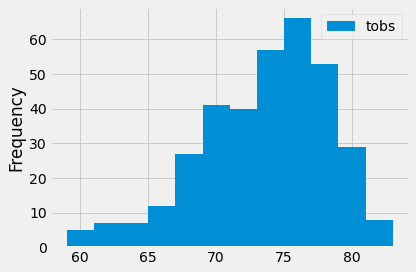

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns = ['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()